In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!ls
!unzip /content/PPM-100.zip -d /content

path_to_my_weights.h5  PPM-100.zip  sample_data
Archive:  /content/PPM-100.zip
   creating: /content/PPM-100/
  inflating: /content/__MACOSX/._PPM-100  
   creating: /content/PPM-100/matte/
  inflating: /content/__MACOSX/PPM-100/._matte  
   creating: /content/PPM-100/image/
  inflating: /content/__MACOSX/PPM-100/._image  
  inflating: /content/PPM-100/matte/14429083354_23c8fddff5_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._14429083354_23c8fddff5_o.jpg  
  inflating: /content/PPM-100/matte/48624730818_67ff3c2811_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._48624730818_67ff3c2811_o.jpg  
  inflating: /content/PPM-100/matte/7085121445_1165c4a561_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._7085121445_1165c4a561_o.jpg  
  inflating: /content/PPM-100/matte/4065842143_71bd1d0b2f_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._4065842143_71bd1d0b2f_o.jpg  
  inflating: /content/PPM-100/matte/50048955706_7d520d5a19_o.jpg  
  inflating: /content/__MACOSX/P

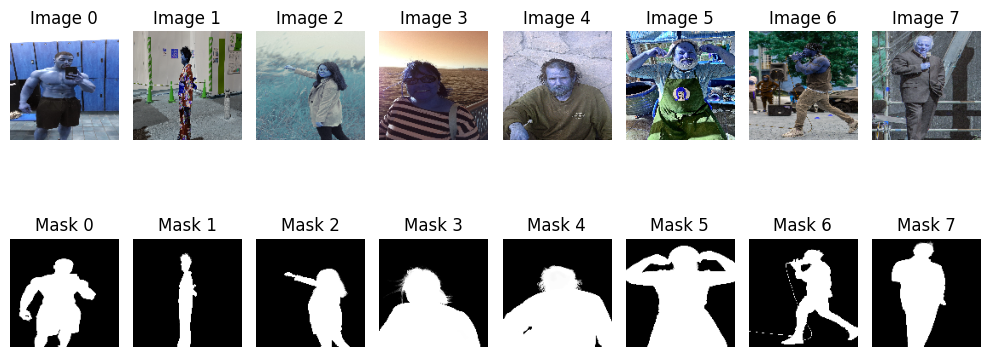

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

class NucleiDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_ids, img_path, batch_size=8, image_size=128):
        self.ids = image_ids
        self.path = img_path
        self.batch_size = batch_size
        self.image_size = image_size

    def __load__(self, id_name):
        image_path = os.path.join(self.path, "image", id_name + ".jpg")
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = image / 255.0

        mask_path = os.path.join(self.path, "matte", id_name + ".jpg")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            batch_ids = self.ids[index * self.batch_size:]
        else:
            batch_ids = self.ids[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for id_name in batch_ids:
            img, msk = self.__load__(id_name)
            images.append(img)
            masks.append(msk)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

# Helper function to get image IDs
def get_image_ids(image_dir):
    return [os.path.splitext(file)[0] for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Replace 'path_to_your_data' with the actual path to your 'image' and 'matte' folders
image_dir = os.path.join('/content/PPM-100', 'image')
image_ids = get_image_ids(image_dir)

# Initialize the data generator
data_gen = NucleiDataGenerator(image_ids=image_ids, img_path='/content/PPM-100')

# Fetch a batch for visualization (assuming that matplotlib is installed)
import matplotlib.pyplot as plt

images, masks = data_gen[0]  # Get the first batch
plt.figure(figsize=(10, 5))

for i in range(len(images)):
    plt.subplot(2, len(images), i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i}")
    plt.axis('off')

    plt.subplot(2, len(images), i+1+len(images))
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Example code to split image IDs into train and validation sets

# Get all image IDs
all_image_ids = get_image_ids(image_dir)  # Assuming image_dir is defined

# Split the IDs into train and validation sets
# This is a simple split. In a real scenario, you would use something like sklearn's train_test_split for better randomization and stratification.
total_images = len(all_image_ids)
train_size = int(0.8 * total_images)  # 80% for training
val_size = int(0.1 * total_images)  # 10% for validation

# Define the sets
train_ids = all_image_ids[:train_size]
valid_ids = all_image_ids[train_size:train_size + val_size]
test_ids = all_image_ids[train_size + val_size:]

# Make sure img_path is defined to point to the directory containing 'image' and 'matte'
img_path = '/content/PPM-100'  # Replace with your actual path
# print(len(train_ids))


In [ ]:
test_ids

['31727147035_ef01d2496d_o',
 '506937171_b73ff1c24b_o',
 '7933140068_61793b7f1e_o',
 '14559969490_d33552a324_o',
 '5588688353_3426d4b5d9_o',
 '7050227021_4898a00341_o',
 '34763377415_22eae5b6bc_o',
 '1991971655_d7182c30e6_o',
 '49158639747_c516378273_o',
 '36959512493_b6c1cc8e4e_o']

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, ZeroPadding2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def crop(o1, o2, i):
    o_shape2 = Model(i, o2).output_shape
    output_height2 = o_shape2[1]
    output_width2 = o_shape2[2]

    o_shape1 = Model(i, o1).output_shape
    output_height1 = o_shape1[1]
    output_width1 = o_shape1[2]

    cx = abs(output_width1 - output_width2)
    cy = abs(output_height1 - output_height2)

    if output_width1 > output_width2:
        o1 = Cropping2D(cropping=((0, 0), (0, cx)))(o1)
    else:
        o2 = Cropping2D(cropping=((0, 0), (0, cx)))(o2)

    if output_height1 > output_height2:
        o1 = Cropping2D(cropping=((0, cy), (0, 0)))(o1)
    else:
        o2 = Cropping2D(cropping=((0, cy), (0, 0)))(o2)

    return o1, o2

def unet():
    inputs = Input((256, 256, 3))
    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling path
    u4 = UpSampling2D((2, 2))(c5)
    c4, u4 = crop(c4, u4, inputs)
    u4 = concatenate([u4, c4])
    u4 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = UpSampling2D((2, 2))(u4)
    c3, u3 = crop(c3, u3, inputs)
    u3 = concatenate([u3, c3])
    u3 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = UpSampling2D((2, 2))(u3)
    c2, u2 = crop(c2, u2, inputs)
    u2 = concatenate([u2, c2])
    u2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = UpSampling2D((2, 2))(u2)
    c1, u1 = crop(c1, u1, inputs)
    u1 = concatenate([u1, c1])
    u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# # Create the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('/content/path_to_my_weights.h5')

In [ ]:
# Replace with your actual data and parameters
train_gen = NucleiDataGenerator(train_ids, img_path, batch_size=8, image_size=128)
valid_gen = NucleiDataGenerator(valid_ids, img_path, batch_size=8, image_size=128)
# print(train_gen, valid_gen)
model.fit(train_gen, validation_data=valid_gen, epochs=25)


Epoch 1/25
10/10 [==============================] - 19s 1s/step - loss: 3.3653 - accuracy: 0.6732 - val_loss: 0.5967 - val_accuracy: 0.6654
Epoch 2/25
10/10 [==============================] - 13s 1s/step - loss: 0.5894 - accuracy: 0.6742 - val_loss: 0.5628 - val_accuracy: 0.6701
Epoch 3/25
10/10 [==============================] - 13s 1s/step - loss: 0.5874 - accuracy: 0.6558 - val_loss: 0.5684 - val_accuracy: 0.6654
Epoch 4/25
10/10 [==============================] - 13s 1s/step - loss: 0.5718 - accuracy: 0.6732 - val_loss: 0.5514 - val_accuracy: 0.6654
Epoch 5/25
10/10 [==============================] - 13s 1s/step - loss: 0.5558 - accuracy: 0.6732 - val_loss: 0.5231 - val_accuracy: 0.6387
Epoch 6/25
10/10 [==============================] - 13s 1s/step - loss: 0.5638 - accuracy: 0.6979 - val_loss: 0.4975 - val_accuracy: 0.7420
Epoch 7/25
10/10 [==============================] - 13s 1s/step - loss: 0.5271 - accuracy: 0.7077 - val_loss: 0.4882 - val_accuracy: 0.7385
Epoch 8/25
10/10 [==

In [ ]:
model.save_weights('path_to_my_weights2.h5')

In [ ]:
test_gen = NucleiDataGenerator(test_ids, img_path, batch_size=1, image_size=128)
results = model.predict(test_gen)

10/10 [==============================] - 2s 184ms/step


In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 2s 186ms/step - loss: 0.3602 - accuracy: 0.8227
Test Loss: 0.36019787192344666
Test Accuracy: 0.82269287109375


In [ ]:
from PIL import Image

print(results.shape)
threshold = 0.5

# Assuming 'results' is the output from model.predict()
# Apply threshold to binarize
bw_results = (results > threshold).astype(np.uint8)*255  # This will create a binary image with 0 and 1

# If you need to save or display these images with standard tools that expect uint8 format:
# bw_results = bw_results * 255
# bw_results = Image.fromarray(bw_results, 'L')

(10, 128, 128, 1)


In [ ]:
def apply_mask(image, mask, background):
    object_pixels = image * mask
    background_pixels = background * (1 - mask)
    return object_pixels + background_pixels

# Assuming background is a numpy array of your chosen background image
# background = ... # Load or define your background image

# background_path = '/content/back.jpg'
# background = cv2.imread(background_path, cv2.IMREAD_COLOR)
# background = cv2.resize(background, (128, 128))

# Convert color from BGR to RGB
# background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Normalize the background if your images are normalized (values between 0 and 1)
# background = background / 255.0
# print("Number of images:", len(images))
# print("Number of masks (results):", len(results))


# Assuming images is a batch of original images and results is the corresponding predicted masks
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    # final_image = apply_mask(images[i], results[i], background)
    # plt.imshow(final_image)
    plt.imshow(bw_results[i])
    plt.show()


In [ ]:
np.save('out', results)
print(results.shape)

(10, 128, 128, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # Convert to array and normalize
    img = np.expand_dims(img, axis=0)  # Expand dims to create a batch of one
    return img

# List of image paths
img_paths = ['/content/0001_img.png', '/content/0500_img.png', '/content/1000_img.png','/content/1500_img.png']
threshold = 0.5

for i, path in enumerate(img_paths):
    # Process the image
    img = load_and_preprocess_image(path)

    # Predict the mask for the image
    result = model.predict(img)

    # Binarize the results
    bw_result = (result > threshold).astype(np.uint8) * 255

    # Convert the result to an image and save or display it
    result_img = Image.fromarray(np.squeeze(bw_result[0]), 'L')  # Squeeze to remove batch dimension
    result_img.save(f'/content/mask_{i}.png')  # Save each result with a unique filename


1/1 [==============================] - 0s 21ms/step
